# Activation statistics

This module includes a series of components that enable us to look inside the model, implemented as callbacks. It is useful in the event that the model is not training.

To do:
1. Implement mean and std as a pytorch hook
2. Implement colourful graph and percentage as a hook
3. Collect into a callback

In [ ]:
#| default_exp activations

In [ ]:
#| export
import math, random, torch, matplotlib.pyplot as plt, numpy as np
from operator import itemgetter
from functools import partial
import fastcore.all as fc
from fastcore import docments

from torch import tensor, nn, optim
import torch.nn.functional as F
from datasets import load_dataset
import torchvision.transforms.functional as TF

from miniai.learner import *
from miniai.datasets import *
from miniai.conv import *

In [ ]:
from torcheval.metrics import MulticlassAccuracy

name = 'fashion_mnist'
ds = load_dataset(name)
bs = 1024

@inplace
def transform(b): b['image'] = [TF.to_tensor(o) for o in b['image']]

tds = ds.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs, num_workers=0)
train, valid = dls.train, dls.valid
xb, yb = next(iter(train))
xb.shape, yb.shape

Found cached dataset fashion_mnist (/Users/olly/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [ ]:
def get_model():
    return nn.Sequential(
        ConvNormAct(1, 4),                 #14x14
        ConvNormAct(4, 8),                 #7x7
        ConvNormAct(8, 16),                #4x4
        ConvNormAct(16, 32),               #2x2
        ConvNormAct(32, 64),               #1x1
        nn.Flatten(),
        nn.Linear(64, 10),
    )

   Train loss  Valid loss  Accuracy
0      0.6629      0.4546    0.8323


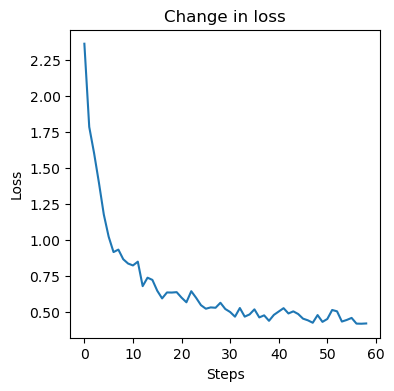

In [ ]:
model = get_model()
cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True)]
learn = BaseLearner(dls, model, cbs=cbs)
learn.fit(0.5, 1, one_cycle=False)

## Mean and standard deviation

When training goes badly, we need to understand what is happening to the activations inside the model. Activations represent the 'work' of the model — they are the output of each layer and thus the transformations applied to the inputs. Tracking the mean and standard deviation of the activations thus gives us an insight into what the model is doing at each layer.


In [ ]:
#| export
def append_stats(hook, module, inp, out):
    """
        Creates lists to store the mean, standard deviation and histogram
        information of layer activations.
    """
    if not hasattr(hook, "stats"): hook.stats = ([], [], [])
    acts = to_cpu(out)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.histc(40, 0, 10))

In [ ]:
#| export
class Hook():
    """
        Base hook class that initialises a Pytorch hook using the function
        passed as an argument.
    """
    def __init__(self, model, func): self.hook = model.register_forward_hook(partial(func, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

The hook class here initialises a Pytorch hook, which is called each time the forward method is called. It passes the `append_stats` function as the function to call. We are passing the Hook class object to the `append_stats` function in order to enable the function to modify its state — this is what enables the stats to be saved inside the Hook object.

   Train loss  Valid loss  Accuracy
0      0.6341      0.4512    0.8369


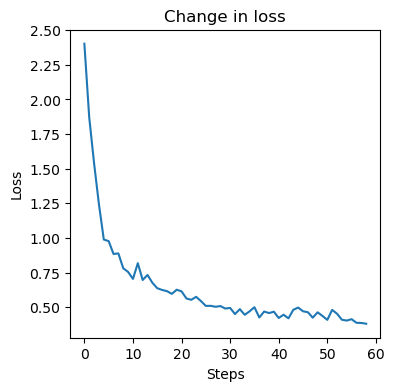

In [ ]:
model = get_model()
hooks = [Hook(l, append_stats) for l in model]
cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True)]
learn = BaseLearner(dls, model, cbs=cbs)
learn.fit(0.5, 1, one_cycle=False)

Now we can access the stats, stored inside the hook objects, and plot that information on a graph.

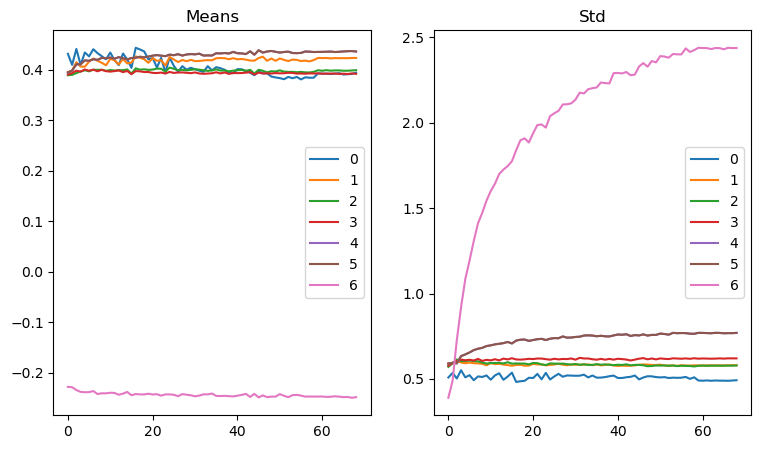

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,5))
for i, h in enumerate(hooks):
    for j in 0,1:
        ax[j].plot(h.stats[j])
        ax[j].set_title("Means" if j == 0 else "Std")
        ax[j].legend(range(len(hooks)))

## Colourful dimension

We can improve on the mean and standard deviation charts by looking at the entire distribution. Of course, it's hard to look at the entire distribution across many training steps in a single chart. However, we can do so by implementing the "colourful dimension" histogram chart from FastAI.

In [ ]:
#| export
def get_hist(h): 
    """
        Takes the list of histogram information stored inside a hook,
        and produces a stacked tensor of log values for layer activations 
        suitable for the colourful dimension chart.
    """
    return torch.stack(h.stats[2]).float().log1p().t().flip(0)

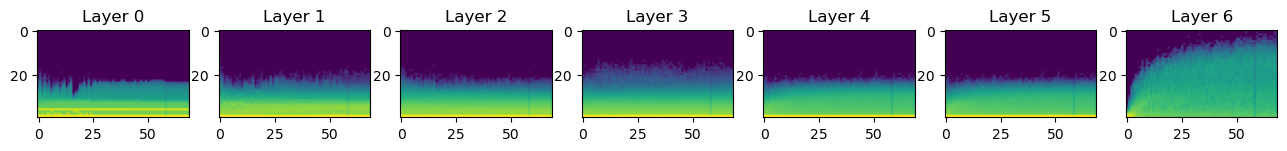

In [ ]:
fig, axes = plt.subplots(1,len(hooks),figsize=(16,10))
for i, (ax, h) in enumerate(zip(axes.flatten(), hooks)):
    ax.imshow(get_hist(h))
    ax.set_title(f"Layer {i}")

## Callback

All of this functionality should be available inside callbacks, so that it can be done automatically.

In [ ]:
#| export
class ActivationStats(Callback):
    """
        Base callback for activation stats which collects and stores statistics,
        including mean, standard deviation and histogram tensor for layer 
        activations. Not used itself — inherited by child classes.
    """
    order = ProgressCB.order + 1
    def __init__(
        self, 
        func, # Function that will be applied to a layer each time forward method is called.
        layer_filter=fc.noop, # Optional function to filter layers to which hooks are applied.
        on_train=True # If true, hooks are applied to training set
    ): 
        fc.store_attr()
        super().__init__()
    def before_fit(self):
        mods = fc.filter_ex(self.learn.model.modules(), self.layer_filter)
        self.hooks = [Hook(l, self.func) for l in mods]
        self.learn.hooks = self
    def __iter__(): return iter(self.hooks)
    def __len__(): return len(self.hooks)

   Train loss  Valid loss  Accuracy
0      0.6553      0.4546     0.833


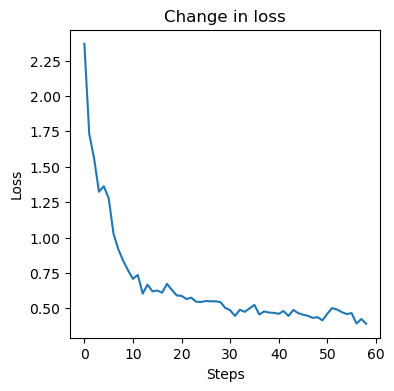

In [ ]:
model = get_model()
cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), ActivationStats(append_stats, layer_filter=fc.risinstance(nn.Conv2d))]
learn = BaseLearner(dls, model, cbs=cbs)
learn.fit(0.5, 1, one_cycle=False)

In [ ]:
#| export
class ColorDim(ActivationStats):
    """
        Plots a stacked histogram of layer activations, using color 
        gradients to represent frequency. Extends the base ActivationStats
        callback.
    """
    def __init__(
        self, 
        func, # Function that will be applied to a layer each time forward method is called.
        layer_filter=fc.noop, # Optional function to filter layers to which hooks are applied.
        on_train=True # If true, hooks are applied to training set.
    ): 
        super().__init__(func, layer_filter, on_train)
        
    def after_fit(self):
        self.plot()        
    def plot(self):
        fig, axes = plt.subplots(1,len(self.hooks),figsize=(16,10))
        for i, (ax, h) in enumerate(zip(axes.flatten(), self.hooks)):
            ax.imshow(get_hist(h))
            ax.set_title(f"Layer {i + 1}")

   Train loss  Valid loss  Accuracy
0      0.7711      0.4878    0.8192


   Train loss  Valid loss  Accuracy
1      0.4255      0.4045    0.8557

 Colourful dimension charts: 
 



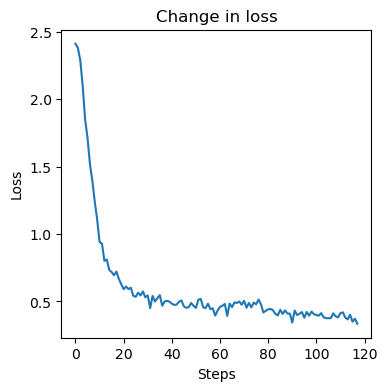

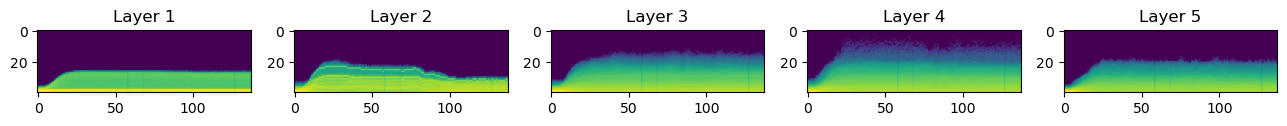

In [ ]:
model = get_model()
cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), ColorDim(append_stats, layer_filter=fc.risinstance(nn.Conv2d))]
learn = BaseLearner(dls, model, cbs=cbs)
learn.fit(0.2, 2, one_cycle=True)

In [ ]:
#| export
class MeanStd(ActivationStats):
    """
        Plots the mean and standard deviation for layer activations. Extends
        the base ActivationStats callback.
    """
    def __init__(
        self, 
        func, # Function that will be applied to a layer each time forward method is called.
        layer_filter=fc.noop, # Optional function to filter layers to which hooks are applied.
        on_train=True # If true, hooks are applied to training set.
    ): 
        super().__init__(func, layer_filter, on_train)
        
    def after_fit(self):
        self.plot()        
    def plot(self):
        fig, ax = plt.subplots(1,2,figsize=(9,5))
        for i, h in enumerate(self.hooks):
            for j in 0,1:
                ax[j].plot(h.stats[j])
                ax[j].set_title("Means" if j == 0 else "Std")
                ax[j].legend(range(len(self.hooks)))

   Train loss  Valid loss  Accuracy
0      0.7792      0.4872    0.8185


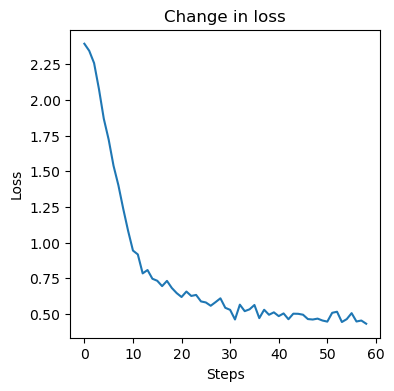

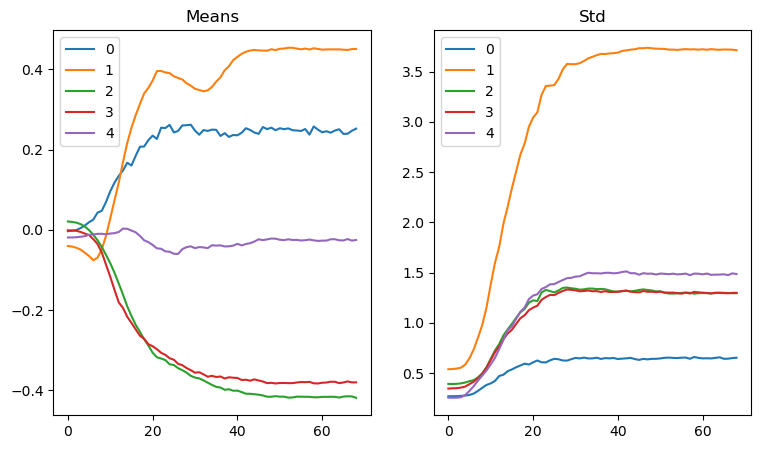

In [ ]:
model = get_model()
cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), MeanStd(append_stats, layer_filter=fc.risinstance(nn.Conv2d))]
learn = BaseLearner(dls, model, cbs=cbs)
learn.fit(0.2, 1, one_cycle=True)

In [ ]:
import nbdev; nbdev.nbdev_export()